## Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report
)


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, LSTM, GRU, Dense, Dropout, Masking, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D, Bidirectional
)
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/delivery.csv')

In [ ]:
df.head()

order_id      order_time    analytical_customer_id  is_acquisition  \
0  544145594  9/1/2021 10:41  6zWSp9yqnEQuq4N6ykRgbbdQ           False   
1  544478492  9/1/2021 18:17  TtmFFw26sQR26nBE2RykhxQA           False   
2  544358032  9/1/2021 15:56  7pB4MC2aBPRdajLH2wPvIvAA           False   
3  544366924  9/1/2021 16:09  AFedsf0e-lSZer_X0eR4VE-g           False   
4  544372362  9/1/2021 16:16  JDYqF36aULSEaWsz604DuuRw           False   

   is_successful reason sub_reason owner delivery_arrangement  gmv_amount_lc  \
0           True    NaN        NaN   NaN                  TGO       134.6900   
1           True    NaN        NaN   NaN                  TGO       134.6454   
2           True    NaN        NaN   NaN                  TGO        84.4900   
3           True    NaN        NaN   NaN                  TGO       320.0130   
4           True    NaN        NaN   NaN                  TGO        83.9900   

   basket_amount_lc  delivery_fee_amount_lc Payment Method  \
0          119.7000                   14.99           Cash   
1          129.6554                    4.99           Cash   
2           79.5000                    4.99           Cash   
3          310.0230                    9.99           Cash   
4           69.0000                   14.99  Online - Card   

   actual_delivery_time  promised_delivery_time  order_delay  \
0                1896.0                  1739.0        157.0   
1                3506.0                  2159.0       1347.0   
2                3357.0                  2159.0       1198.0   
3                3237.0                  2519.0        718.0   
4                1216.0                  1499.0       -283.0   

   dropoff_distance_manhattan platform vertical_class vertical  \
0                      3294.0      iOS           food     food   
1                      1911.0  android           food     food   
2                       560.0  android           food     food   
3                      1380.0  android           food     food   
4                      1902.0  android           food     food   

   is_affordable_freedelivery  is_affordable_item  is_affordable_gem  \
0                       False               False              False   
1                       False               False              False   
2                       False               False              False   
3                       False               False              False   
4                       False               False              False   

   is_affordable_restaurant  is_affordable_voucher  is_affordable  \
0                     False                  False          False   
1                     False                  False          False   
2                     False                  False          False   
3                     False                  False          False   
4                     False                  False          False   

   affordability_amt_total     City  
0                      NaN  Chennai  
1                      NaN  Chennai  
2                      NaN  Chennai  
3                      NaN  Chennai  
4                      NaN  Chennai

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42075 entries, 0 to 42074
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order_id                    42075 non-null  int64  
 1   order_time                  42075 non-null  object 
 2   analytical_customer_id      42074 non-null  object 
 3   is_acquisition              42074 non-null  object 
 4   is_successful               42074 non-null  object 
 5   reason                      7350 non-null   object 
 6   sub_reason                  3052 non-null   object 
 7   owner                       7350 non-null   object 
 8   delivery_arrangement        42074 non-null  object 
 9   gmv_amount_lc               42074 non-null  float64
 10  basket_amount_lc            42074 non-null  float64
 11  delivery_fee_amount_lc      42074 non-null  float64
 12  Payment Method              42074 non-null  object 
 13  actual_delivery_time        287

## EDA

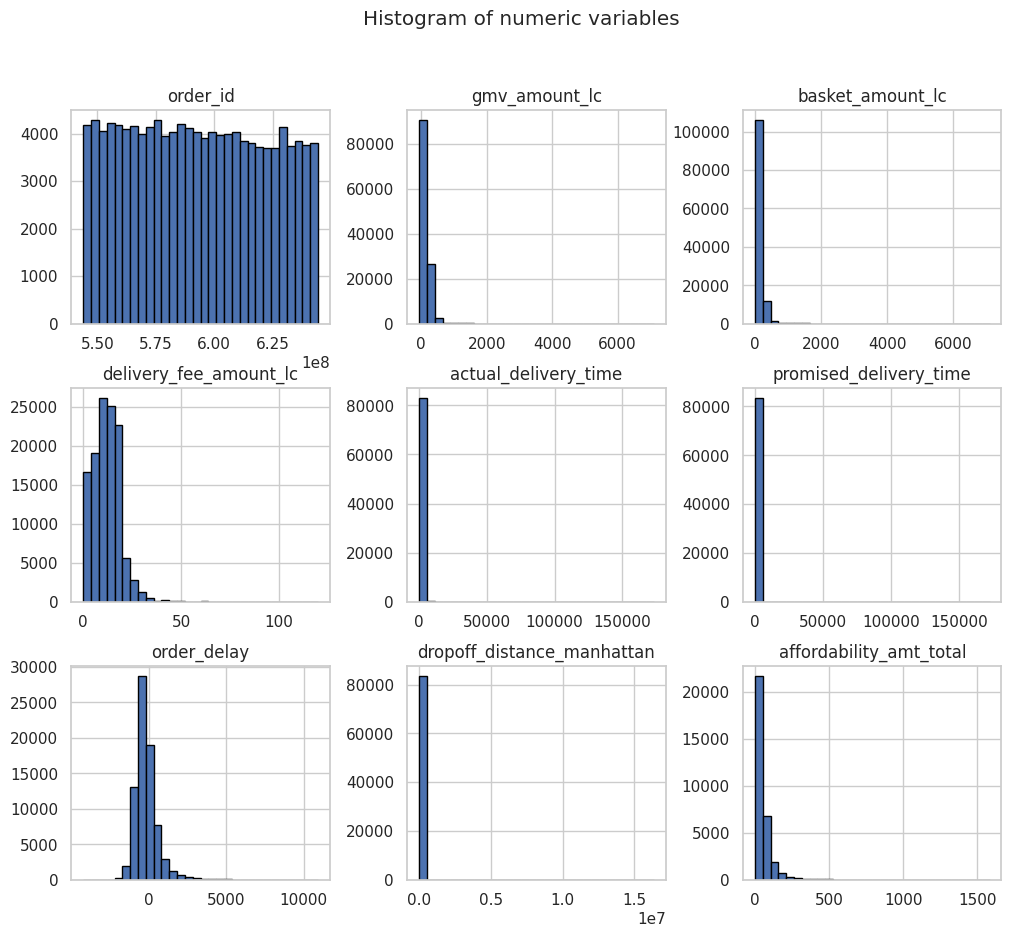

In [ ]:
sns.set(style='whitegrid')

df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Histogram of numeric variables')
plt.show()


In [ ]:
numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr().round(2)

fig = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.index,
        colorscale='RdBu',
        zmin=-1,
        zmax=1,
        text=corr_matrix.values,
        texttemplate="%{text}"
    )
)

fig.update_layout(
    title='Correlation Matrix',
    xaxis_nticks=len(corr_matrix.columns),
    yaxis_nticks=len(corr_matrix.index)
)
fig.show()


In [ ]:

fig = px.histogram(df, x="is_successful", color="is_successful",
                   color_discrete_sequence=px.colors.diverging.RdBu,
                   category_orders={"is_successful": [0, 1]},
                   labels={"is_successful": "Is Successful"},
                   title="Order Success Distribution")
fig.update_layout(xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=["Failed", "Successful"]),
                  yaxis_title="Count")
fig.show()

fig = px.box(df, x="order_delay", title="Order Delay Distribution",
             labels={"order_delay": "Order Delay (minutes)"}, color_discrete_sequence=["skyblue"])
fig.show()

fig = px.histogram(df, x="gmv_amount_lc", nbins=50, marginal="rug", color_discrete_sequence=["green"],
                   title="GMV Amount Distribution",
                   labels={"gmv_amount_lc": "GMV Amount (Local Currency)"})
fig.update_layout(yaxis_title="Frequency")
fig.show()

fig = px.histogram(df, y="platform", color="platform",
                   category_orders={"platform": df["platform"].value_counts().index.tolist()},
                   title="Order Count per Platform")
fig.update_layout(xaxis_title="Count", yaxis_title="Platform", showlegend=False)
fig.show()

fig = px.box(df, x="is_successful", y="dropoff_distance_manhattan",
             color="is_successful", color_discrete_sequence=px.colors.diverging.RdBu,
             category_orders={"is_successful": [0, 1]},
             labels={"is_successful": "Is Successful", "dropoff_distance_manhattan": "Dropoff Distance (Manhattan)"},
             title="Dropoff Distance vs Order Success")
fig.update_layout(xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=["Failed", "Successful"]))
fig.show()


In [ ]:
counts = df['is_successful'].value_counts().sort_index()
counts_df = pd.DataFrame({
    'is_successful': counts.index.astype(str),
    'count': counts.values
})

fig = px.bar(counts_df, x='is_successful', y='count',
             color='is_successful',
             labels={'is_successful': 'Is successful', 'count': 'Count'},
             title='Distribution of successful orders')

fig.update_layout(showlegend=False)
fig.show()

In [ ]:


counts = df['is_successful'].value_counts().sort_index()
labels = counts.index.astype(str)
values = counts.values
custom_colors = ['#ff9999', '#66b3ff']

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    textinfo='label+percent',
    marker=dict(colors=custom_colors)
)])

fig.update_layout(
    title='Distribution of successful orders'
)
fig.show()

In [ ]:

counts = df['is_acquisition'].value_counts().sort_index()
counts_df = pd.DataFrame({
    'is_acquisition': counts.index.astype(str),
    'count': counts.values
})

fig = px.bar(
    counts_df,
    x='is_acquisition',
    y='count',
    color='is_acquisition',
    labels={'is_acquisition': 'Is acquisition', 'count': 'Count'},
    title='Distribution of acquisition orders'
)

fig.update_layout(showlegend=False)
fig.show()

In [ ]:

counts = df['reason'].value_counts()
counts_df = pd.DataFrame({
    'reason': counts.index,
    'count': counts.values
})

fig = px.bar(
    counts_df,
    x='reason',
    y='count',
    color='reason',
    labels={'reason': 'Reason', 'count': 'Count'},
    title='Distribution of reasons of failure'
)

fig.update_layout(
    xaxis_tickangle=-45,
    showlegend=False
)

fig.show()

In [ ]:

counts = df['reason'].value_counts()
threshold = 0.015
filtered_counts = counts[counts / counts.sum() >= threshold]
other_count = counts[counts / counts.sum() < threshold].sum()
filtered_counts['OTHERS'] = other_count

magma_colors = plt.cm.get_cmap("magma", len(filtered_counts))
custom_colors = [magma_colors(i) for i in range(len(filtered_counts))]
custom_colors_hex = ['#%02x%02x%02x' % tuple(int(c * 300) for c in color[:3]) for color in custom_colors]

labels = [
    f'{label} ({value / filtered_counts.sum() * 100:.1f}%)'
    for label, value in zip(filtered_counts.index, filtered_counts.values)
]

fig = go.Figure(data=[go.Pie(
    labels=filtered_counts.index,
    values=filtered_counts.values,
    marker=dict(colors=custom_colors_hex),
    text=labels,
    hoverinfo='label+percent',
)])

fig.update_layout(
    title='Distribution of reasons of failure',
    legend=dict(
        traceorder='normal',
        x=1,
        y=0.8
    )
)

fig.show()


<ipython-input-57-c7d1fb111037>:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [ ]:
counts = df['sub_reason'].value_counts()

magma_colors = plt.cm.get_cmap("magma", len(counts))
custom_colors = [magma_colors(i) for i in range(len(counts))]
custom_colors_hex = ['#%02x%02x%02x' % tuple(int(c * 400) for c in color[:3]) for color in custom_colors]

labels = [
    f'{label} ({value / counts.sum() * 100:.1f}%)'
    for label, value in zip(counts.index, counts.values)
]

fig = go.Figure(data=[go.Pie(
    labels=counts.index,
    values=counts.values,
    marker=dict(colors=custom_colors_hex),
    text=labels,
    hoverinfo='label+percent'
)])

fig.update_layout(
    title='Distribution of sub reasons of failure',
    legend=dict(
        traceorder='normal',
        x=1,
        y=0.8
    )
)

fig.show()


<ipython-input-58-fd40ea87106e>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [ ]:

counts = df['delivery_arrangement'].value_counts()
counts_df = pd.DataFrame({
    'delivery_arrangement': counts.index.astype(str),
    'count': counts.values
})

custom_colors = ['#5fa2ce','#f1c3c2']

fig = px.bar(
    counts_df,
    x='delivery_arrangement',
    y='count',
    color='delivery_arrangement',
    color_discrete_sequence=custom_colors,
    labels={'delivery_arrangement': 'Delivery arrangement', 'count': 'Count'},
    title='Distribution of delivery arrangement'
)

fig.update_layout(showlegend=False)
fig.show()

In [ ]:

counts = df['platform'].value_counts()
platforms = counts.index.astype(str)
values = counts.values

custom_colors = ['#5fa2ce', '#8fa2ce','#4aa8aa','#5de2ce']
bar_colors = [custom_colors[i % len(custom_colors)] for i in range(len(platforms))]

fig = go.Figure(data=[
    go.Bar(
        x=platforms,
        y=values,
        marker_color=bar_colors
    )
])

fig.update_layout(
    title='Distribution of platforms',
    xaxis_title='Platform',
    yaxis_title='Count',
    xaxis_tickangle=45,
    height=500,
    width=800,
    showlegend=False
)

fig.show()


In [ ]:

counts = df.groupby(['platform', 'is_successful']).size().reset_index(name='count')
custom_colors = ['#5fa2ce','#f1c3c2']
fig = px.bar(
    counts,
    x='platform',
    y='count',
    color='is_successful',
    barmode='group',
    color_discrete_sequence=custom_colors,
    labels={'platform': 'Platform', 'count': 'Count', 'is_successful': 'Is Successful'},
    title='Countplot of successful orders by platform'
)

fig.update_layout(
    xaxis_tickangle=0,
    height=500,
    width=900
)

fig.show()


In [ ]:

counts = df.groupby(["Payment Method", 'is_successful']).size().reset_index(name='count')
custom_colors = ['#5fa2ce','#f1c3c2']
fig = px.bar(
    counts,
    x='Payment Method',
    y='count',
    color='is_successful',
    barmode='group',
    color_discrete_sequence=custom_colors,
    labels={'Payment Method': 'Payment Method', 'count': 'Count', 'is_successful': 'Is Successful'},
    title='Distribution of payment methods'
)

fig.update_layout(
    xaxis_tickangle=0,
    height=500,
    width=900
)

fig.show()

In [ ]:
counts = df['vertical_class'].value_counts()
counts_df = pd.DataFrame({
    'vertical_class': counts.index.astype(str),
    'count': counts.values
})

custom_colors = ['#5fa2ce','#f1c3c2']

fig = px.bar(
    counts_df,
    x='vertical_class',
    y='count',
    color='vertical_class',
    color_discrete_sequence=custom_colors,
    labels={'vertical_class': 'Vertical class', 'count': 'Count'},
    title='Distribution of vertical classes'
)

fig.update_layout(
    xaxis_tickangle=45,
    xaxis_tickfont=dict(size=10),
    showlegend=False,
    height=500,
    width=900
)

fig.show()


In [ ]:
df['order_time'] = pd.to_datetime(df['order_time'], format='mixed', errors='coerce')
df['order_day'] = df['order_time'].dt.date

num_orders_per_day = df.groupby('order_day')['order_id'].count()

fig = go.Figure(data=go.Scatter(
    x=num_orders_per_day.index,
    y=num_orders_per_day.values,
    mode='lines+markers',
    name='Number of Orders',
    line=dict(color='blue'),
    marker=dict(size=6)
))

fig.update_layout(
    title='Number of Orders per Day',
    xaxis_title='Date',
    yaxis_title='Number of Orders',
    xaxis=dict(tickangle=45),
    template='simple_white',
    height=500,
    width=1000
)

fig.show()


In [ ]:
avg_actual_delivery_time_per_day = df.groupby('order_day')['actual_delivery_time'].mean()
avg_promised_delivery_time_per_day = df.groupby('order_day')['promised_delivery_time'].mean()

colors = ['#5fa2ce', '#f1c3c2']


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=avg_actual_delivery_time_per_day.index,
    y=avg_actual_delivery_time_per_day.values,
    mode='lines+markers',
    name='Average Actual Delivery Time',
    line=dict(color=colors[0]),
    marker=dict(size=6)
))

fig.add_trace(go.Scatter(
    x=avg_promised_delivery_time_per_day.index,
    y=avg_promised_delivery_time_per_day.values,
    mode='lines+markers',
    name='Average Promised Delivery Time',
    line=dict(color=colors[1]),
    marker=dict(size=6)
))

fig.update_layout(
    title='Comparison of Actual and Promised Delivery Time per Day',
    xaxis_title='Date',
    yaxis_title='Average Delivery Time in seconds',
    xaxis=dict(tickangle=45),
    height=600,
    width=1200,
    legend_title='Delivery Time Type'
)

fig.show()

In [ ]:
counts = df['City'].value_counts()
cities = counts.index.astype(str)
values = counts.values

custom_colors = [
    '#ffb6c1',
    '#add8e6',
    '#db7093',
    '#87cefa',
    '#ff69b4',
    '#4682b4',
    '#ffc0cb',
    '#6495ed',
    '#ff82ab',
    '#5fa2ce',
    '#fcb6c1',
    '#afd8e6',
    '#fb7093',
    '#97ceda',
    '#8969b4',
    '#7682b4',
    '#ddc0cb',
    '#9497ed',
    '#da82ab',
    '#8aa2ce'
]

bar_colors = [custom_colors[i % len(custom_colors)] for i in range(len(cities))]

fig = go.Figure(data=[
    go.Bar(
        x=cities,
        y=values,
        marker_color=bar_colors
    )
])

fig.update_layout(
    title='Distribution of cities (logarithmic)',
    xaxis_title='City',
    yaxis_title='Count (log scale)',
    xaxis_tickangle=45,
    yaxis_type='log',
    yaxis_range=[0, None],
    height=600,
    width=1200,
    showlegend=False
)

fig.show()


In [ ]:


orders_per_day_per_city = df.groupby(['order_day', 'City']).size().unstack()

fig = go.Figure()

for i, city in enumerate(orders_per_day_per_city.columns):
    fig.add_trace(go.Scatter(
        x=orders_per_day_per_city.index,
        y= orders_per_day_per_city[city],
        mode='lines+markers',
        name=city,
        marker=dict(size=6)
    ))

fig.update_layout(
    title='Number of Orders per Day per City',
    xaxis_title='Date',
    yaxis_title='Number of Orders',
    xaxis=dict(tickangle=45),
    legend_title='City',
    height=600,
    width=1200,
)

fig.show()

In [ ]:

avg_delay_per_day_per_city = df.groupby(['order_day', 'City'])['order_delay'].mean().unstack()
avg_delay_per_day_per_city_filtered = avg_delay_per_day_per_city[avg_delay_per_day_per_city > 0]


fig = go.Figure()

for i, city in enumerate(avg_delay_per_day_per_city_filtered.columns):
    fig.add_trace(go.Scatter(
        x=avg_delay_per_day_per_city_filtered.index,
        y=avg_delay_per_day_per_city_filtered[city],
        mode='lines+markers',
        name=city,
        marker=dict(size=6)
    ))

fig.update_layout(
    title='Average Order Delay Time per Day per City',
    xaxis_title='Date',
    yaxis_title='Average Order Delay Time',
    xaxis=dict(tickangle=45),
    legend_title='City',
    height=600,
    width=1200,
)

fig.show()



In [ ]:

def get_grouped_counts(df, x_col, hue_col):
    return df.groupby([x_col, hue_col]).size().reset_index(name='count')

fig = make_subplots(rows=2, cols=2, subplot_titles=[
    "is_affordable_freedelivery",
    "is_affordable_item",
    "is_affordable_gem",
    "is_affordable_restaurant"
])

affordable_cols = [
    "is_affordable_freedelivery",
    "is_affordable_item",
    "is_affordable_gem",
    "is_affordable_restaurant"
]

for i, col in enumerate(affordable_cols):
    grouped = get_grouped_counts(df, col, 'is_successful')
    row, col_num = divmod(i, 2)
    row += 1
    col_num += 1

    for success_value in sorted(grouped['is_successful'].unique()):
        subset = grouped[grouped['is_successful'] == success_value]
        fig.add_trace(go.Bar(
            x=subset[col].astype(str),
            y=subset['count'],
            name=f'Successful={success_value}',
            marker_color=colors[success_value],
            showlegend=(i == 0)
        ), row=row, col=col_num)

fig.update_layout(
    height=700,
    width=1000,
    title_text="Affordability Flags vs Order Success",
    barmode='group'
)

fig.show()


In [ ]:
city_coordinates = {
    'Ahmedabad': {'lat': 23.0225, 'lon': 72.5714},
    'Bengaluru': {'lat': 12.9716, 'lon': 77.5946},
    'Chennai': {'lat': 13.0827, 'lon': 80.2707},
    'Coimbatore': {'lat': 11.0168, 'lon': 76.9558},
    'Delhi': {'lat': 28.6139, 'lon': 77.209},
    'Gurgaon': {'lat': 28.4595, 'lon': 77.0266},
    'Hyderabad': {'lat': 17.385, 'lon': 78.4867},
    'Jaipur': {'lat': 26.9124, 'lon': 75.7873},
    'Jodhpur': {'lat': 26.2389, 'lon': 73.0243},
    'Kochi': {'lat': 9.9312, 'lon': 76.2673},
    'Kolkata': {'lat': 22.5726, 'lon': 88.3639},
    'Lucknow': {'lat': 26.8467, 'lon': 80.9462},
    'Ludhiana': {'lat': 30.901, 'lon': 75.8573},
    'Madurai': {'lat': 9.9252, 'lon': 78.1198},
    'Manali': {'lat': 32.2396, 'lon': 77.1887},
    'Mumbai': {'lat': 19.076, 'lon': 72.8777},
    'Mysore': {'lat': 12.2958, 'lon': 76.6394},
    'Nagpur': {'lat': 21.1458, 'lon': 79.0882},
    'Ooty': {'lat': 11.4067, 'lon': 76.6932},
    'Pune': {'lat': 18.5204, 'lon': 73.8567},
    'Rourkela': {'lat': 22.2587, 'lon': 84.9011},
    'Trivandrum': {'lat': 8.5241, 'lon': 76.9366},
    'Vadodara': {'lat': 22.3072, 'lon': 73.1812}
}

orders_per_city = df.groupby('City')['order_id'].count().reset_index()
orders_per_city.columns = ['City', 'Number_of_Orders']

orders_per_city['lat'] = orders_per_city['City'].apply(lambda x: city_coordinates[x]['lat'])
orders_per_city['lon'] = orders_per_city['City'].apply(lambda x: city_coordinates[x]['lon'])

fig = px.scatter_mapbox(orders_per_city, lat="lat", lon="lon", hover_name="City", hover_data=["Number_of_Orders"],
                        size="Number_of_Orders", color="Number_of_Orders", size_max=50,
                        mapbox_style="carto-positron", zoom=4, title='Number of Orders per City in India')
fig.show()

In [ ]:
def plot_pie_plotly(data, labels, title, colors=None):
    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=data,
        marker=dict(colors=colors) if colors else None,
        textinfo='percent+label',
        hoverinfo='label+percent',
    )])

    fig.update_layout(
        title=title,
        height=600,
        width=600,
        showlegend=True
    )
    fig.show()

success_counts = df["is_successful"].value_counts().sort_index()
plot_pie_plotly(
    data=success_counts.values,
    labels=["Successful", "Failed"],
    title="Order Success Distribution",
    colors=["lightgreen", "red"]
)

payment_counts = df["Payment Method"].value_counts().nlargest(5)
plot_pie_plotly(
    data=payment_counts.values,
    labels=payment_counts.index,
    title="Top 5 Payment Methods",
    colors=["blue", "pink", "lightgreen", "violet", "tan"]
)

platform_counts = df["platform"].value_counts()
plot_pie_plotly(
    data=platform_counts.values,
    labels=platform_counts.index,
    title="Orders by Platform",
    colors=["pink", "mint", "salmon","lightgreen", "darkblue"]
)

vertical_counts = df["vertical_class"].value_counts()
plot_pie_plotly(
    data=vertical_counts.values,
    labels=vertical_counts.index,
    title="Orders by Vertical Class",
    colors=["mint", "lightblue", "lightgreen", "salmon", "orchid", "tan"]
)

## Pre-processing

In [ ]:
df = df[df['is_successful'].notna()]

In [ ]:
for col in ['dropoff_distance_manhattan', 'delivery_fee_amount_lc', 'gmv_amount_lc', 'basket_amount_lc','affordability_amt_total']:
  df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

Time features creation

In [ ]:
df['order_time'] = pd.to_datetime(df['order_time'])
df['order_hour'] = df['order_time'].dt.hour
df['order_dayofweek'] = df['order_time'].dt.dayofweek
df['order_month'] = df['order_time'].dt.month

for col in ['gmv_amount_lc', 'order_delay', 'affordability_amt_total']:
    df[f'{col}_lag1'] = df.groupby('analytical_customer_id')[col].shift(1)
    df[f'{col}_rolling_mean_3'] = df.groupby('analytical_customer_id')[col] \
                                    .transform(lambda x: x.shift(1).rolling(3).mean())

In [ ]:
df['is_weekend'] = df['order_time'].dt.dayofweek >= 5

In [ ]:
df['cumulative_orders_per_customer'] = df.groupby('analytical_customer_id').cumcount()

In [ ]:
df['days_since_last_order'] = df.groupby('analytical_customer_id')['order_time'].diff().dt.days

In [ ]:
df['order_week'] = df['order_time'].dt.isocalendar().week

In [ ]:
def get_part_of_day(hour):
    if 5 <= hour < 11:
        return 'morning'
    elif 11 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['part_of_day'] = df['order_time'].dt.hour.apply(get_part_of_day)

In [ ]:
df.fillna(method='ffill', inplace = True)

In [ ]:
columns_to_drop = [
    'order_id',
    'order_time',
    'reason',
    'sub_reason',
    'owner',
    'vertical',
    'order_delay',
    'is_acquisition',


]
df.drop(columns=columns_to_drop, inplace=True)

Multicoliniarity analysis

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
columns_to_remove = ['order_id', 'analytical_customer_id']
df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)

df_vif_full = df.select_dtypes(include=[np.number]).copy()
df_vif_full = df_vif_full.astype(float)
df_vif_full = df_vif_full.replace([np.inf, -np.inf], 0)

vif_data_full = pd.DataFrame()
vif_data_full['feature'] = df_vif_full.columns
df_vif_full.fillna(0, inplace = True)
vif_data_full['VIF'] = [variance_inflation_factor(df_vif_full.values, i) for i in range(df_vif_full.shape[1])]

vif_data_full

feature         VIF
0                            gmv_amount_lc  107.113174
1                         basket_amount_lc  101.339687
2                   delivery_fee_amount_lc    5.136828
3                     actual_delivery_time    3.381870
4                   promised_delivery_time    3.679833
5               dropoff_distance_manhattan    1.001799
6                  affordability_amt_total    1.826556
7                               order_hour    6.772677
8                          order_dayofweek    3.290606
9                              order_month   53.117128
10                      gmv_amount_lc_lag1    4.158226
11            gmv_amount_lc_rolling_mean_3    5.040802
12                        order_delay_lag1    1.158180
13              order_delay_rolling_mean_3    1.351102
14            affordability_amt_total_lag1    1.832820
15  affordability_amt_total_rolling_mean_3    3.077939
16          cumulative_orders_per_customer    1.536826
17                   days_since_last_order    1.294970
18                              order_week   67.174735

If VIF value > 10 -> there is a muliticolinearity issue, therefore we have to get rid of come features such as order_week and 'basket_amount_lc', because basket_amount_lc already is in gmv_amount_lc.

In [ ]:
columns_to_drop_due_to_vif = [
    'basket_amount_lc',
    'order_week'

]
df.drop(columns=[col for col in columns_to_drop_due_to_vif if col in df.columns], inplace=True)

In [ ]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:
df = df.fillna(0)

print("Final data size:", df.shape)
df.head()

Final data size: (119885, 58)


is_successful  gmv_amount_lc  delivery_fee_amount_lc  actual_delivery_time  \
0           True       134.6900                   14.99                1896.0   
1           True       134.6454                    4.99                3506.0   
2           True        84.4900                    4.99                3357.0   
3           True       320.0130                    9.99                3237.0   
4           True        83.9900                   14.99                1216.0   

   promised_delivery_time  dropoff_distance_manhattan  \
0                  1739.0                      3294.0   
1                  2159.0                      1911.0   
2                  2159.0                       560.0   
3                  2519.0                      1380.0   
4                  1499.0                      1902.0   

   is_affordable_freedelivery  is_affordable_item  is_affordable_gem  \
0                       False               False              False   
1                       False               False              False   
2                       False               False              False   
3                       False               False              False   
4                       False               False              False   

   is_affordable_restaurant  is_affordable_voucher  is_affordable  \
0                     False                  False          False   
1                     False                  False          False   
2                     False                  False          False   
3                     False                  False          False   
4                     False                  False          False   

   affordability_amt_total  order_hour  order_dayofweek  order_month  \
0                      0.0          10                2            9   
1                      0.0          18                2            9   
2                      0.0          15                2            9   
3                      0.0          16                2            9   
4                      0.0          16                2            9   

   gmv_amount_lc_lag1  gmv_amount_lc_rolling_mean_3  order_delay_lag1  \
0                 0.0                           0.0               0.0   
1                 0.0                           0.0               0.0   
2                 0.0                           0.0               0.0   
3                 0.0                           0.0               0.0   
4                 0.0                           0.0               0.0   

   order_delay_rolling_mean_3  affordability_amt_total_lag1  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   
3                         0.0                           0.0   
4                         0.0                           0.0   

   affordability_amt_total_rolling_mean_3  is_weekend  \
0                                     0.0       False   
1                                     0.0       False   
2                                     0.0       False   
3                                     0.0       False   
4                                     0.0       False   

   cumulative_orders_per_customer  days_since_last_order  \
0                               0                    0.0   
1                               0                    0.0   
2                               0                    0.0   
3                               0                    0.0   
4                               0                    0.0   

   delivery_arrangement_TMP  Payment Method_Online - Card  \
0                     False                         False   
1                     False                         False   
2                     False                         False   
3                     False                         False   
4                     False                          True   

   

## Modeling

In [ ]:
X = df.drop('is_successful', axis=1)
y = df['is_successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)

In [ ]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
pip install imbalanced-learn

### Baseline model

In [ ]:
baseline_model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

report_base = classification_report(y_test, y_pred_base, output_dict=True)
conf_matrix_base = confusion_matrix(y_test, y_pred_base)

accuracy = accuracy_score(y_test, y_pred_base)
precision = precision_score(y_test, y_pred_base)
recall = recall_score(y_test, y_pred_base)
f1 = f1_score(y_test, y_pred_base)

summary = f"""
Accuracy of Logistic Regression (Baseline) (with class_weight='balanced'): {accuracy * 100:.2f}%
Precision: {precision:.2f}
Recall: {recall:.2f}
F1 Score: {f1:.2f}"""
print(summary)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

smote_model = LogisticRegression(max_iter=1000, solver='liblinear')
smote_model.fit(X_train_sm, y_train_sm)
y_pred_smote = smote_model.predict(X_test)

report_smote = classification_report(y_test, y_pred_smote, output_dict=True)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)

accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)

summary = f"""
Accuracy of Logistic Regression with Oversampling): {accuracy * 100:.2f}%
Precision: {precision:.2f}
Recall: {recall:.2f}
F1 Score: {f1:.2f}"""
print(summary)

metrics_df = pd.DataFrame({
    'Baseline (weighted)': report_base['weighted avg'],
    'SMOTE': report_smote['weighted avg']
}).T

metrics_df.round(3)



Accuracy of Logistic Regression (Baseline) (with class_weight='balanced'): 85.78%
Precision: 0.97
Recall: 0.85
F1 Score: 0.91

Accuracy of Logistic Regression with Oversampling): 86.42%
Precision: 0.95
Recall: 0.89
F1 Score: 0.92


precision  recall  f1-score  support
Baseline (weighted)      0.901   0.858     0.870  35966.0
SMOTE                    0.884   0.864     0.871  35966.0

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


### Classic Models

In [ ]:
models = {
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42,n_estimators=25,max_depth=10, min_samples_split=2)
    },
    'LightGBM': {
        'model': LGBMClassifier(class_weight='balanced', random_state=42, n_estimators=25, max_depth=10)
    },
    'CatBoost': {
        'model': CatBoostClassifier(verbose=0, random_state=42, iterations=25, depth = 10)
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42,n_estimators = 25, max_depth = 5)
    },
    'GaussianNB': {
        'model': GaussianNB()
    },
    'ElasticNet': {
        'model': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,
                                   class_weight='balanced', max_iter=1000, random_state=42)
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(n_estimators=50, max_depth=10, class_weight='balanced', random_state=42)
    }
}


results = []

def evaluate_model(name, model, X_train, y_train, X_test, y_test, use_smote=False):
    if use_smote:
        pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('clf', model)
        ])
    else:
        pipeline = Pipeline([('clf', model)])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return {
        'Model': name + (' + SMOTE' if use_smote else ''),
        'Accuracy': round(acc * 100, 2),
        'Precision': round(prec, 2),
        'Recall': round(rec, 2),
        'F1 Score': round(f1, 2),
        'Confusion Matrix': cm
    }

for name, conf in models.items():
    print(name)
    model = conf['model']
    results.append(evaluate_model(name, model, X_train, y_train, X_test, y_test, use_smote=False))
    results.append(evaluate_model(name, model, X_train, y_train, X_test, y_test, use_smote=True))

summary_df = pd.DataFrame([{k: v for k, v in res.items() if k != 'Confusion Matrix'} for res in results])

summary_df


RandomForest
LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 70118, number of negative: 13801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3325
[LightGBM] [Info] Number of data points in the train set: 83919, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 70118, number of negative: 70118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



ExtraTrees


Model  Accuracy  Precision  Recall  F1 Score
0               RandomForest     96.84       0.99    0.97      0.98
1       RandomForest + SMOTE     97.33       0.99    0.98      0.98
2                   LightGBM     98.41       0.99    0.99      0.99
3           LightGBM + SMOTE     98.31       0.99    0.99      0.99
4                   CatBoost     99.51       0.99    1.00      1.00
5           CatBoost + SMOTE     99.39       1.00    1.00      1.00
6           GradientBoosting     98.15       0.98    1.00      0.99
7   GradientBoosting + SMOTE     96.24       0.99    0.96      0.98
8                 GaussianNB     81.67       0.85    0.95      0.90
9         GaussianNB + SMOTE     75.31       0.89    0.81      0.85
10                ElasticNet     92.11       0.92    0.99      0.95
11        ElasticNet + SMOTE     90.80       0.92    0.97      0.95
12                ExtraTrees     83.93       0.98    0.82      0.90
13        ExtraTrees + SMOTE     84.84       0.93    0.89      0.91

In [ ]:


param_grids = {
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {
            'n_estimators': [100,25,50],
            'max_depth': [10,5],
            'min_samples_split': [2,3]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(class_weight='balanced', random_state=42),
        'params': {
            'n_estimators':  [100,25,50],
            'max_depth': [5,10]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(verbose=1, random_state=42),
        'params': {
            'iterations': [25,100,50],
            'depth': [10,5,3]
        }
    }
}

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

best_models = {}

for name, config in param_grids.items():
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(
        config['model'],
        config['params'],
        scoring='f1',
        cv=3,
        n_jobs=2,
        error_score='raise',
        verbose=1
    )
    grid.fit(X_train_sm, y_train_sm)
    best_models[name] = grid.best_estimator_
    print(f"Best for {name}: {grid.best_params_}")



Running GridSearchCV for RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best for RandomForest: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100}
Running GridSearchCV for LightGBM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 70118, number of negative: 70118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3692
[LightGBM] [Info] Number of data points in the train set: 140236, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best for LightGBM: {'max_depth': 10, 'n_estimators': 100}
Running GridSearchCV for CatBoost...
Fitting 3 folds for each of 9 candid

Best Model Visualisations

Accuracy: 97.24%
Precision: 0.99
Recall: 0.98
F1 Score: 0.98


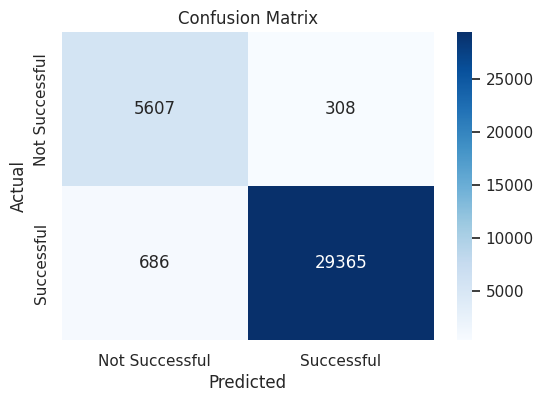

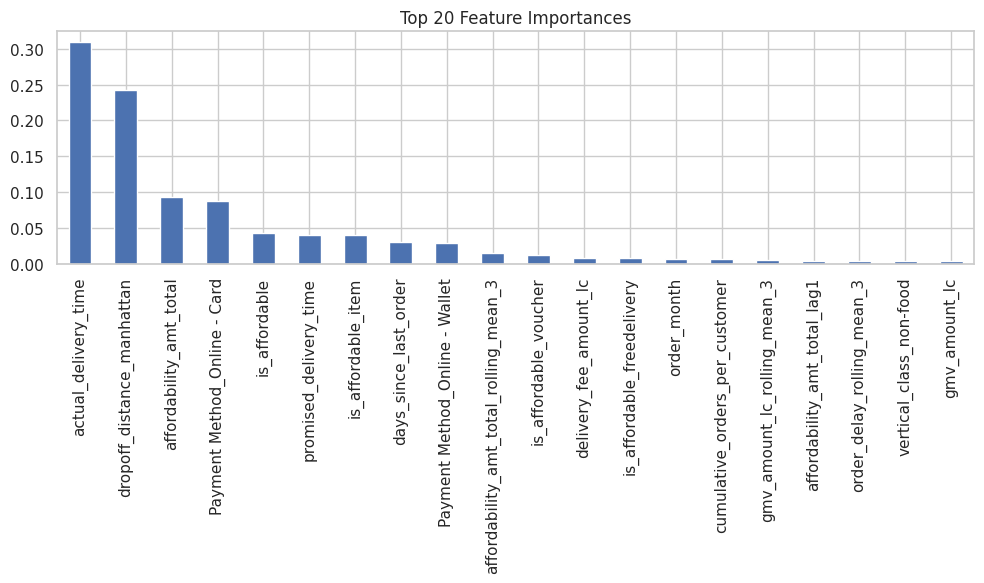

In [ ]:

model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Successful', 'Successful'], yticklabels=['Not Successful', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

importances = model.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


Accuracy: 99.49%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


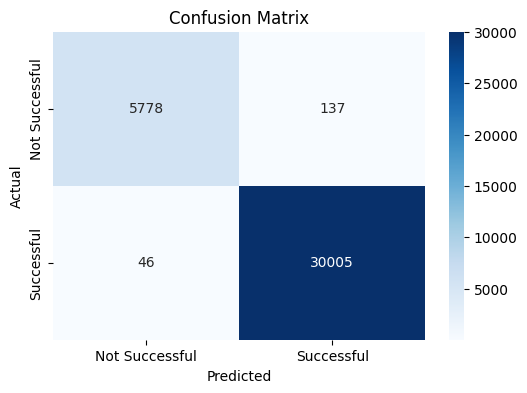

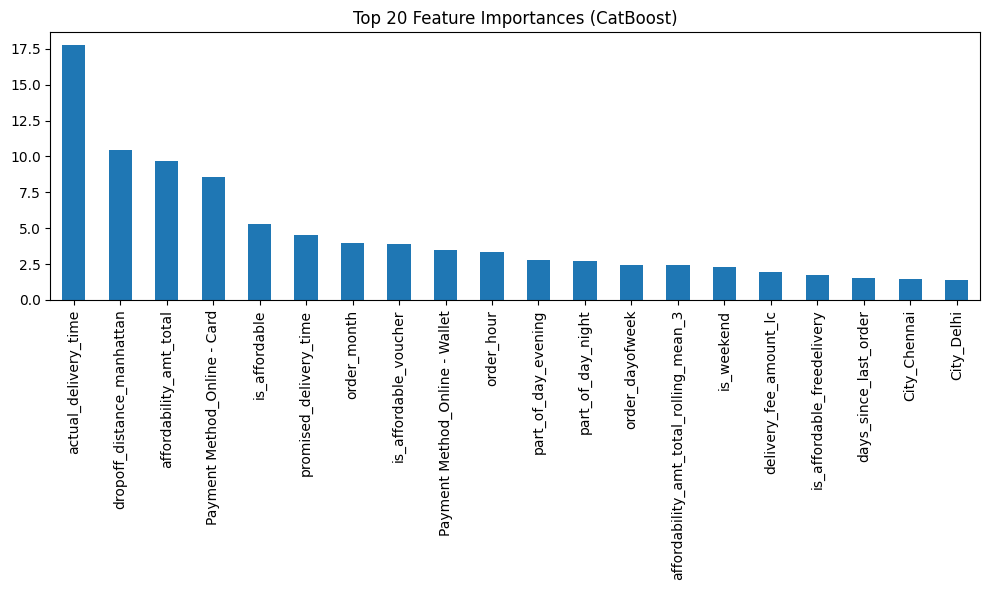

In [ ]:
model = CatBoostClassifier(
    iterations=100,
    depth=10,
    class_weights=[1, 1],
    random_state=42,
    verbose=0
)
model.fit(X_train_sm, y_train_sm)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

importances = model.get_feature_importance()
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances (CatBoost)')
plt.tight_layout()
plt.show()


### Model Averaging and Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier, VotingClassifier


rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
nb = GaussianNB()

voting = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('nb', nb)
    ],
    voting='soft'
)
voting.fit(X_train_sm, y_train_sm)
y_pred_vote = voting.predict(X_test)

stacking = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('nb', nb)
    ],
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    cv=3
)
stacking.fit(X_train_sm, y_train_sm)
y_pred_stack = stacking.predict(X_test)

def print_metrics(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.2%}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.2f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.2f}")

print_metrics("Model Averaging (Voting)", y_test, y_pred_vote)
print_metrics("Model Stacking", y_test, y_pred_stack)



=== Model Averaging (Voting) ===
Accuracy:  98.42%
Precision: 0.99
Recall:    0.99
F1 Score:  0.99

=== Model Stacking ===
Accuracy:  99.03%
Precision: 0.99
Recall:    0.99
F1 Score:  0.99


Stacking for boosting models

In [ ]:
cat = CatBoostClassifier(verbose=0, iterations=50, depth=4, learning_rate=0.1, random_state=42)
lgb = LGBMClassifier(n_estimators=50, max_depth=4, learning_rate=0.1, class_weight='balanced', random_state=42)

meta = LogisticRegression(max_iter=1000, class_weight='balanced')

stacking = StackingClassifier(
    estimators=[('cat', cat), ('lgb', lgb)],
    final_estimator=meta,
    cv=3
)

stacking.fit(X_train_sm, y_train_sm)
y_pred_stack = stacking.predict(X_test)


print_metrics("Stacking with CatBoost + LightGBM", y_test, y_pred_stack)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 70118, number of negative: 70118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3692
[LightGBM] [Info] Number of data points in the train set: 140236, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

### Neural Networks

In [ ]:
df = pd.read_csv("delivery.csv")
df['order_time'] = pd.to_datetime(df['order_time'])
df = df.sort_values(by=['analytical_customer_id', 'order_time'])

df['order_hour'] = df['order_time'].dt.hour
df['order_dayofweek'] = df['order_time'].dt.dayofweek
df['order_month'] = df['order_time'].dt.month
df['is_weekend'] = df['order_dayofweek'] >= 5
df['days_since_last'] = df.groupby('analytical_customer_id')['order_time'].diff().dt.days.fillna(0)

features = ['order_hour', 'order_dayofweek', 'order_month', 'is_weekend',
            'gmv_amount_lc', 'delivery_fee_amount_lc', 'order_delay', 'days_since_last']
df = df.dropna(subset=features + ['is_successful'])

In [ ]:
X_seqs = []
y_seqs = []

for customer_id, group in df.groupby('analytical_customer_id'):
    X_seq = group[features].values
    y_seq = group['is_successful'].values
    if len(X_seq) > 1:
        X_seqs.append(X_seq)
        y_seqs.append(y_seq[-1])

X_padded = pad_sequences(X_seqs, padding='post', dtype='float32')
y = np.array(y_seqs)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, stratify=y, random_state=42)

#### LSTM

In [ ]:
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

y_pred = model.predict(X_test).ravel()
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels))

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.8776 - loss: 0.3424 - val_accuracy: 0.9961 - val_loss: 0.0274
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 226ms/step - accuracy: 0.9904 - loss: 0.0509 - val_accuracy: 0.9961 - val_loss: 0.0232
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.9915 - loss: 0.0466 - val_accuracy: 0.9961 - val_loss: 0.0234
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - accuracy: 0.9913 - loss: 0.0493 - val_accuracy: 0.9961 - val_loss: 0.0233
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.9921 - loss: 0.0438 - val_accuracy: 0.9961 - val_loss: 0.0228
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - accuracy: 0.9905 - loss: 0.0498 - val_accuracy: 0.9961 - val_loss: 0.0227
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.9940 - loss: 0.0326 - val_accuracy: 0.9961 - val_loss: 0.0236
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.9903 - loss: 0.0485 - val_accu

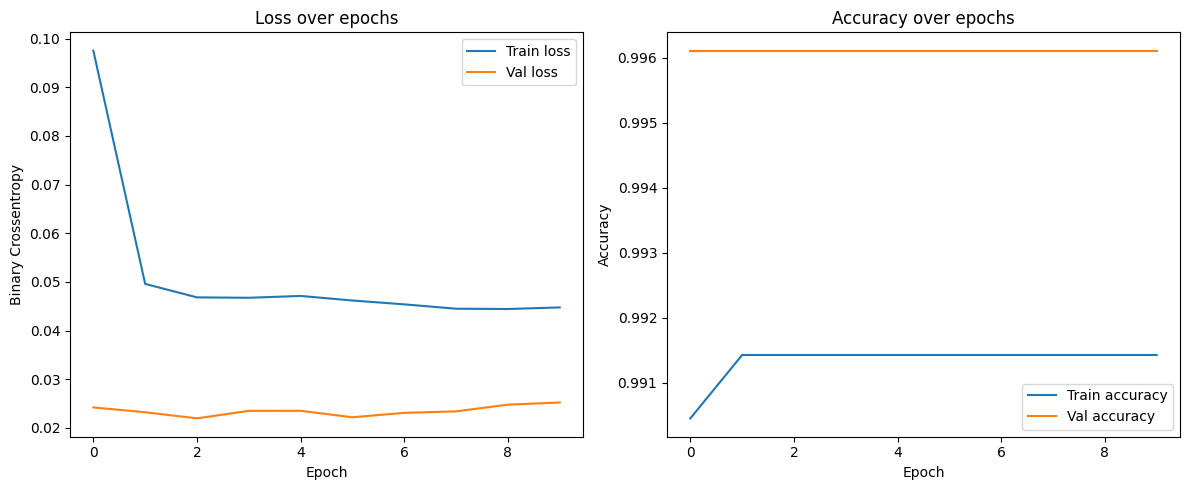

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

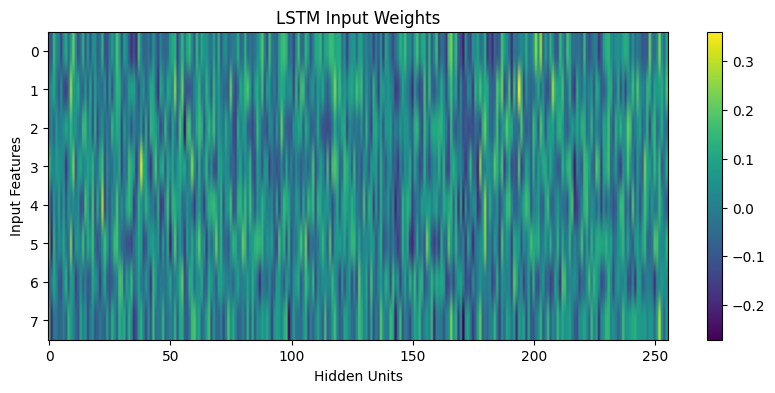

In [ ]:
lstm_weights = model.layers[1].get_weights()[0]
plt.figure(figsize=(10, 4))
plt.imshow(lstm_weights, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('LSTM Input Weights')
plt.xlabel('Hidden Units')
plt.ylabel('Input Features')
plt.show()

#### GRU

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - accuracy: 0.9449 - loss: 0.1625 - val_accuracy: 0.9961 - val_loss: 0.0245
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - accuracy: 0.9927 - loss: 0.0504 - val_accuracy: 0.9961 - val_loss: 0.0255
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 231ms/step - accuracy: 0.9942 - loss: 0.0394 - val_accuracy: 0.9961 - val_loss: 0.0259
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.9913 - loss: 0.0492 - val_accuracy: 0.9961 - val_loss: 0.0233
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.9886 - loss: 0.0660 - val_accuracy: 0.9961 - val_loss: 0.0232
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.9911 - loss: 0.0506 - val_accuracy: 0.9961 - val_loss: 0.0235
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.9923 - loss: 0.0425 - val_accuracy: 0.9961 - val_loss: 0.0249
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.9911 - loss: 0.0525 - val_accu

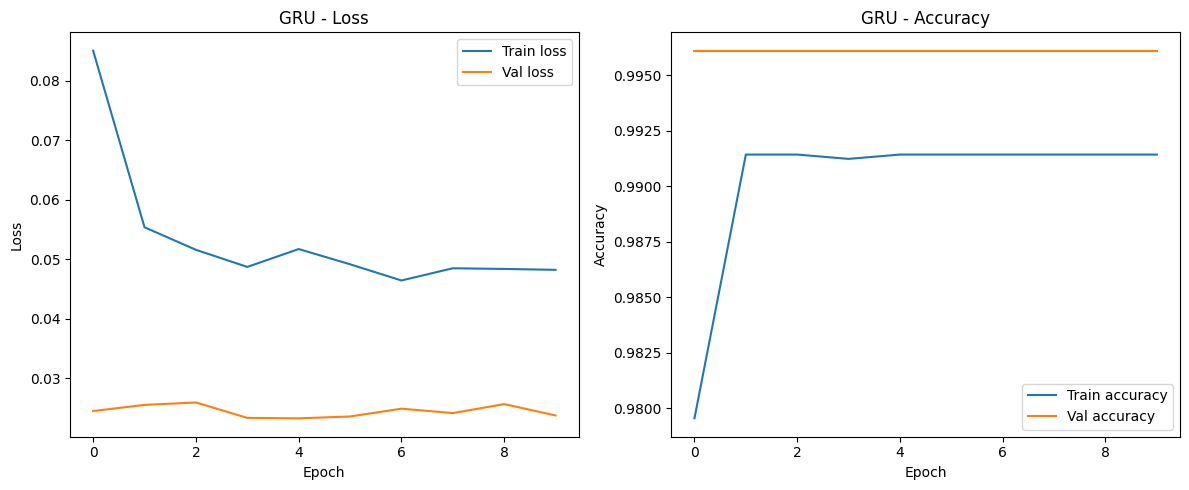

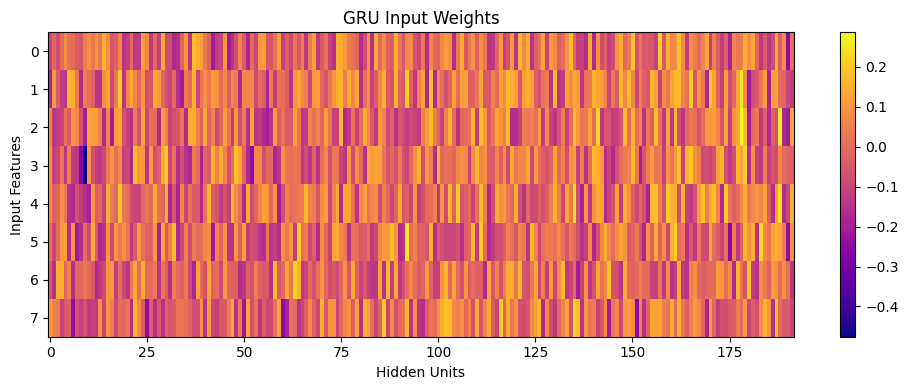

In [ ]:
gru_model = Sequential()
gru_model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(GRU(64, return_sequences=False))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(32, activation='relu'))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

gru_history = gru_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Val accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(gru_history, "GRU")

def plot_weights(model, title):
    weights = model.layers[1].get_weights()[0]
    plt.figure(figsize=(10, 4))
    plt.imshow(weights, aspect='auto', cmap='plasma')
    plt.colorbar()
    plt.title(f'{title} Input Weights')
    plt.xlabel('Hidden Units')
    plt.ylabel('Input Features')
    plt.tight_layout()
    plt.show()

plot_weights(gru_model, "GRU")


#### Bidirectional LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 322ms/step - accuracy: 0.9491 - loss: 0.2004 - val_accuracy: 0.9961 - val_loss: 0.0225
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 304ms/step - accuracy: 0.9904 - loss: 0.0505 - val_accuracy: 0.9961 - val_loss: 0.0224
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 316ms/step - accuracy: 0.9922 - loss: 0.0409 - val_accuracy: 0.9961 - val_loss: 0.0230
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - accuracy: 0.9908 - loss: 0.0485 - val_accuracy: 0.9961 - val_loss: 0.0223
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 305ms/step - accuracy: 0.9923 - loss: 0.0399 - val_accuracy: 0.9961 - val_loss: 0.0223
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 298ms/step - accuracy: 0.9929 - loss: 0.0381 - val_accuracy: 0.9961 - val_loss: 0.0241
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 304ms/step - accuracy: 0.9884 - loss: 0.0572 - val_accuracy: 0.9961 - val_loss: 0.0211
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 323ms/step - accuracy: 0.9907 - loss: 0.0483 - val_accu

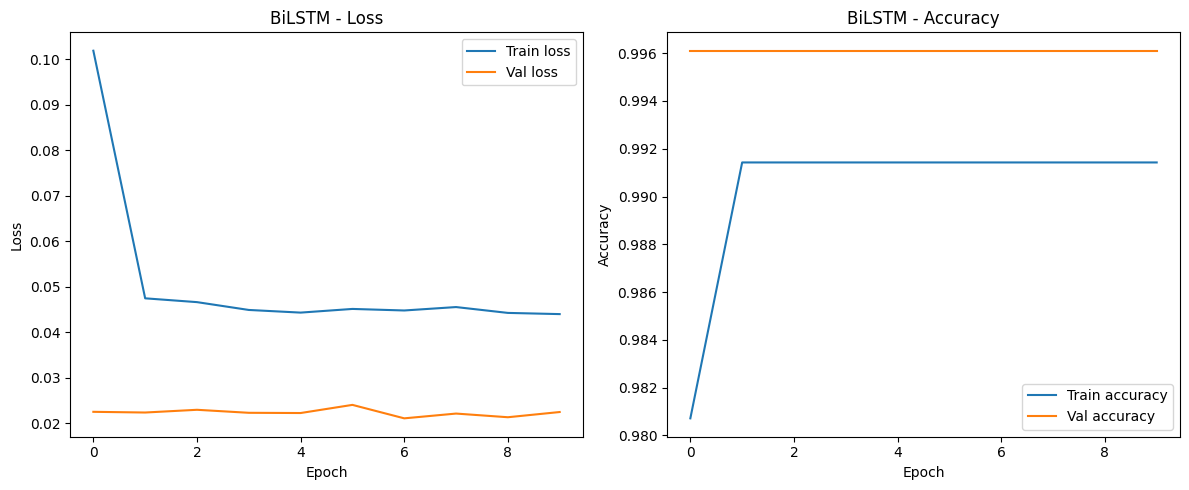

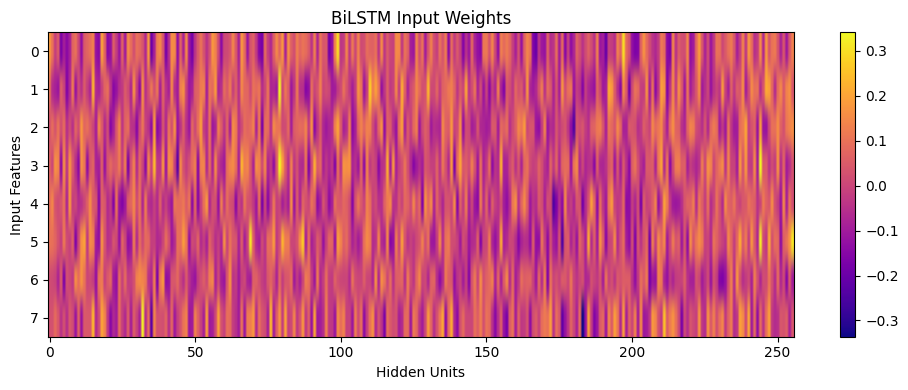

In [ ]:
bilstm_model = Sequential()
bilstm_model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=False)))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Dense(32, activation='relu'))
bilstm_model.add(Dense(1, activation='sigmoid'))

bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

bilstm_history = bilstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

plot_history(bilstm_history, "BiLSTM")

plot_weights(bilstm_model, "BiLSTM")


#### LSTM + Multi-Head Attention

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 57s 600ms/step - accuracy: 0.7714 - loss: 0.4101 - val_accuracy: 0.9961 - val_loss: 0.0240
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 52s 644ms/step - accuracy: 0.9921 - loss: 0.0442 - val_accuracy: 0.9961 - val_loss: 0.0244
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 630ms/step - accuracy: 0.9912 - loss: 0.0493 - val_accuracy: 0.9961 - val_loss: 0.0229
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 628ms/step - accuracy: 0.9924 - loss: 0.0460 - val_accuracy: 0.9961 - val_loss: 0.0242
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 84s 656ms/step - accuracy: 0.9906 - loss: 0.0510 - val_accuracy: 0.9961 - val_loss: 0.0236
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 80s 635ms/step - accuracy: 0.9935 - loss: 0.0369 - val_accuracy: 0.9961 - val_loss: 0.0258
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 629ms/step - accuracy: 0.9907 - loss: 0.0509 - val_accuracy: 0.9961 - val_loss: 0.0243
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 83s 643ms/step - accuracy: 0.9893 - loss: 0.0583 - val_accu

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00        12
        True       0.99      1.00      1.00      1592

    accuracy                           0.99      1604
   macro avg       0.50      0.50      0.50      1604
weighted avg       0.99      0.99      0.99      1604



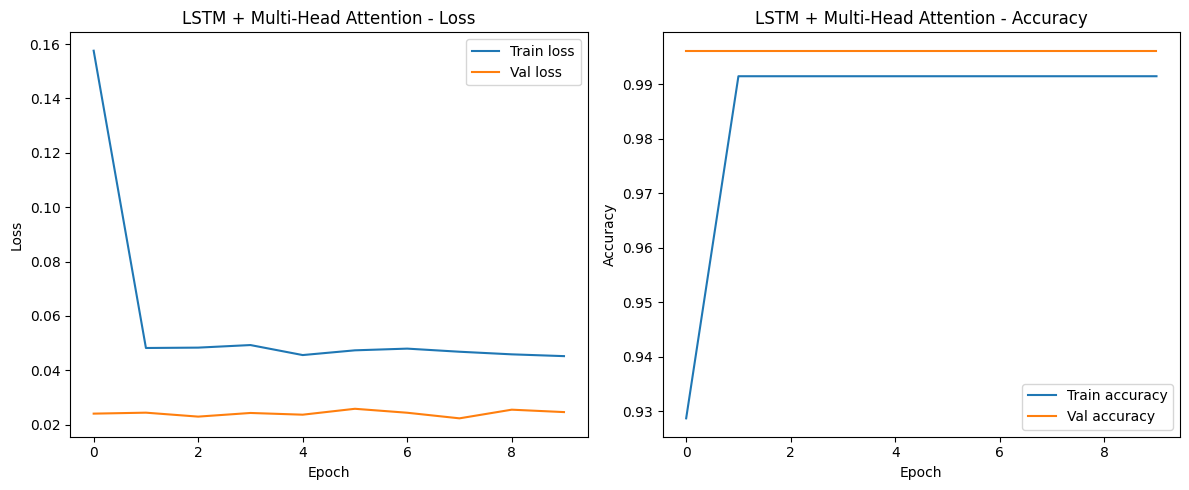

In [ ]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
masked = Masking(mask_value=0.)(input_layer)
lstm_out = LSTM(64, return_sequences=True)(masked)

attention_out = MultiHeadAttention(num_heads=4, key_dim=16)(lstm_out, lstm_out)
attention_out = LayerNormalization(epsilon=1e-6)(attention_out + lstm_out)  # Add & Norm

pooled = GlobalAveragePooling1D()(attention_out)
drop = Dropout(0.3)(pooled)
dense = Dense(32, activation='relu')(drop)
dense_2 = Dense(16, activation='relu')(dense)
output = Dense(1, activation='sigmoid')(dense_2)

mha_model = Model(inputs=input_layer, outputs=output)
mha_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = mha_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

y_pred = mha_model.predict(X_test).ravel()
y_pred_labels = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_labels))


plot_history(history,title="LSTM + Multi-Head Attention")

#### Transformers

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.7914 - loss: 0.4783 - val_accuracy: 0.9961 - val_loss: 0.0581
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9915 - loss: 0.1025 - val_accuracy: 0.9961 - val_loss: 0.0288
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9917 - loss: 0.0773 - val_accuracy: 0.9961 - val_loss: 0.0260
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9920 - loss: 0.0634 - val_accuracy: 0.9961 - val_loss: 0.0257
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9919 - loss: 0.0640 - val_accuracy: 0.9961 - val_loss: 0.0253
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9904 - loss: 0.0658 - val_accuracy: 0.9961 - val_loss: 0.0253
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9907 - loss: 0.0646 - val_accuracy: 0.9961 - val_loss: 0.0252
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9911 - loss: 0.0610 - val_accuracy: 0.9961 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


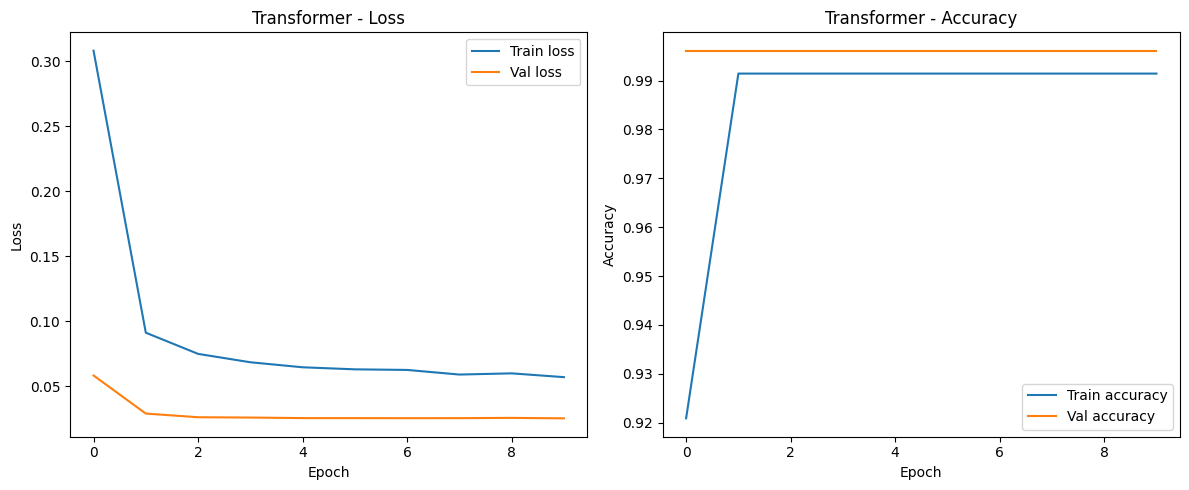

In [ ]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_len, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(sequence_len, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / tf.pow(10000., (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return angles

    def positional_encoding(self, sequence_len, d_model):
      pos = tf.range(sequence_len, dtype=tf.float32)[:, tf.newaxis]   # (T, 1)
      i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]          # (1, D)

      angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / d_model)
      angle_rads = pos * angle_rates

      sines = tf.math.sin(angle_rads[:, 0::2])
      cosines = tf.math.cos(angle_rads[:, 1::2])
      pos_encoding = tf.concat([sines, cosines], axis=-1)
      pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # (1, T, D)

      return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dense(inputs.shape[-1])(ff)
    ff = layers.Dropout(dropout)(ff)
    x = layers.LayerNormalization(epsilon=1e-6)(ff + x)
    return x

def build_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_layers=2, dropout=0.1):
    inputs = layers.Input(shape=input_shape)
    x = PositionalEncoding(sequence_len=input_shape[0], d_model=input_shape[1])(inputs)

    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)


input_shape = X_train.shape[1:]
trans_model = build_model(input_shape)
trans_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = trans_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

y_pred = trans_model.predict(X_test).ravel()
y_pred_label = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_label))

plot_history(history, title="Transformer")


In [ ]:
def build_advanced_transformer(input_shape, head_size=64, num_heads=4, ff_dim=128, num_layers=2, dropout=0.2):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    pos = PositionalEncoding(sequence_len=input_shape[0], d_model=x.shape[-1])(x)

    for _ in range(num_layers):
        attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(pos, pos)
        attn_out = layers.Dropout(dropout)(attn_out)
        x = layers.LayerNormalization(epsilon=1e-6)(attn_out + pos)

        ff = layers.Dense(ff_dim, activation="gelu")(x)
        ff = layers.Dense(x.shape[-1])(ff)
        ff = layers.Dropout(dropout)(ff)
        pos = layers.LayerNormalization(epsilon=1e-6)(ff + x)

    x = layers.GlobalAveragePooling1D()(pos)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs)

Epoch 1/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9688 - loss: 0.0963 - val_accuracy: 0.9961 - val_loss: 0.0292
Epoch 2/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9914 - loss: 0.0557 - val_accuracy: 0.9961 - val_loss: 0.0254
Epoch 3/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9911 - loss: 0.0573 - val_accuracy: 0.9961 - val_loss: 0.0248
Epoch 4/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9901 - loss: 0.0589 - val_accuracy: 0.9961 - val_loss: 0.0257
Epoch 5/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9911 - loss: 0.0521 - val_accuracy: 0.9961 - val_loss: 0.0262
Epoch 6/6
81/81 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9925 - loss: 0.0458 - val_accuracy: 0.9961 - val_loss: 0.0257
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 267ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00        12
        True       0.99      1.00      1.00      1592

    accuracy                           0.99      1604
   macro avg       0.50      0.50      0.50      1604
weighted avg       0.99      0.99      0.99      1604



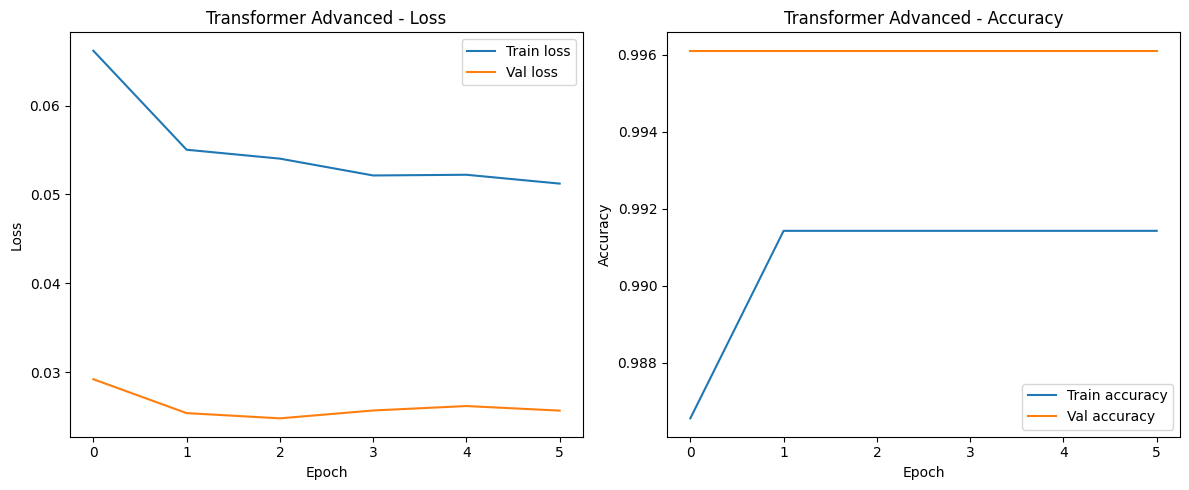

In [ ]:
input_shape = X_train.shape[1:]
adv_trans_model = build_advanced_transformer(input_shape)
adv_trans_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = adv_trans_model.fit(X_train, y_train, epochs=6, batch_size=64, validation_split=0.2)

y_pred = adv_trans_model.predict(X_test).ravel()
y_pred_label = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_label))

plot_history(history, title="Transformer Advanced")


#### Model Compatison

In [ ]:
models_to_evaluate = [
    ("GRU", gru_model),
    ("BiLSTM", bilstm_model),
    ("LSTM", model),
    ("LSTM + Attention", mha_model),
    ("Transformer (Encoder-only)", trans_model),
    ("Transformer (Advanced)", adv_trans_model)
]

results = []

for name, model_instance in models_to_evaluate:
    y_pred = model_instance.predict(X_test).ravel()
    y_pred_label = (y_pred > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_label)
    prec = precision_score(y_test, y_pred_label)
    rec = recall_score(y_test, y_pred_label)
    f1 = f1_score(y_test, y_pred_label)

    results.append({
        "Model": name,
        "Accuracy": round(acc * 100, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4)
    })

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


In [ ]:
results_df = pd.DataFrame(results)
results_df

Model  Accuracy  Precision  Recall  F1 Score
0                      BiLSTM   99.5800     0.9958     1.0    0.9989
1            LSTM + Attention   99.2530     0.9929     1.0    0.9987
2                        LSTM   99.3100     0.9931     1.0    0.9970
3      Transformer (Advanced)   99.2582     0.9925     1.0    0.9969
4                         GRU   99.2519     0.9925     1.0    0.9962
5  Transformer (Encoder-only)   99.1560     0.9915     1.0    0.9942

In [ ]:
print('Final results table')
results = [
    ['RandomForest', 96.84, 0.99, 0.97, 0.98],
    ['RandomForest + SMOTE', 97.33, 0.99, 0.98, 0.98],
    ['LightGBM', 98.41, 0.99, 0.99, 0.99],
    ['LightGBM + SMOTE', 98.31, 0.99, 0.99, 0.99],
    ['CatBoost', 99.51, 0.99, 1.00, 1.00],
    ['CatBoost + SMOTE', 99.39, 1.00, 1.00, 1.00],
    ['GradientBoosting', 98.15, 0.98, 1.00, 0.99],
    ['GradientBoosting + SMOTE', 96.24, 0.99, 0.96, 0.98],
    ['GaussianNB', 81.67, 0.85, 0.95, 0.90],
    ['GaussianNB + SMOTE', 75.31, 0.89, 0.81, 0.85],
    ['ElasticNet', 92.11, 0.92, 0.99, 0.95],
    ['ElasticNet + SMOTE', 90.80, 0.92, 0.97, 0.95],
    ['ExtraTrees', 83.93, 0.98, 0.82, 0.90],
    ['ExtraTrees + SMOTE', 84.84, 0.93, 0.89, 0.91],
    ['GRU', 99.2519, 0.9925, 1.00, 0.9962],
    ['BiLSTM', 99.58, 0.9958, 1.00, 0.9989],
    ['LSTM', 99.31, 0.9931, 1.00, 0.997],
    ['LSTM + Attention', 99.2530, 0.9929, 1.00, 0.9987],
    ['Transformer (Encoder-only)', 99.156, 0.9915, 1.00, 0.9942],
    ['Transformer (Advanced)', 99.2582, 0.9925, 1.00, 0.9969],
    ['Voting (GradientBoosting + GaussianNB + RF)', 98.42, 0.99, 0.99, 0.99],
    ['Stacking (GradientBoosting + GaussianNB + RF)', 99.03, 0.99, 0.99, 0.99],
    ['Stacking (CatBoost + LightGBM)', 97.82, 0.99, 0.98, 0.99]
]


df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

df_results



Final results table


Model  Accuracy  Precision  \
0                                    RandomForest   96.8400     0.9900   
1                            RandomForest + SMOTE   97.3300     0.9900   
2                                        LightGBM   98.4100     0.9900   
3                                LightGBM + SMOTE   98.3100     0.9900   
4                                        CatBoost   99.5100     0.9900   
5                                CatBoost + SMOTE   99.3900     1.0000   
6                                GradientBoosting   98.1500     0.9800   
7                        GradientBoosting + SMOTE   96.2400     0.9900   
8                                      GaussianNB   81.6700     0.8500   
9                              GaussianNB + SMOTE   75.3100     0.8900   
10                                     ElasticNet   92.1100     0.9200   
11                             ElasticNet + SMOTE   90.8000     0.9200   
12                                     ExtraTrees   83.9300     0.9800   
13                             ExtraTrees + SMOTE   84.8400     0.9300   
14                                            GRU   99.2519     0.9925   
15                                         BiLSTM   99.5800     0.9958   
16                                           LSTM   99.3100     0.9931   
17                               LSTM + Attention   99.2530     0.9929   
18                     Transformer (Encoder-only)   99.1560     0.9915   
19                         Transformer (Advanced)   99.2582     0.9925   
20    Voting (GradientBoosting + GaussianNB + RF)   98.4200     0.9900   
21  Stacking (GradientBoosting + GaussianNB + RF)   99.0300     0.9900   
22                 Stacking (CatBoost + LightGBM)   97.8200     0.9900   

    Recall  F1 Score  
0     0.97    0.9800  
1     0.98    0.9800  
2     0.99    0.9900  
3     0.99    0.9900  
4     1.00    1.0000  
5     1.00    1.0000  
6     1.00    0.9900  
7     0.96    0.9800  
8     0.95    0.9000  
9     0.81    0.8500  
10    0.99    0.9500  
11    0.97    0.9500  
12    0.82    0.9000  
13    0.89    0.9100  
14    1.00    0.9962  
15    1.00    0.9989  
16    1.00    0.9970  
17    1.00    0.9987  
18    1.00    0.9942  
19    1.00    0.9969  
20    0.99    0.9900  
21    0.99    0.9900  
22    0.98    0.9900